In [1]:
%pip install xarray netCDF4 matplotlib
%pip install scipy



  Using cached netcdf4-1.7.3-cp311-abi3-macosx_14_0_arm64.whl.metadata (1.9 kB)
  Using cached cftime-1.6.5-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.7 kB)
Using cached netcdf4-1.7.3-cp311-abi3-macosx_14_0_arm64.whl (2.4 MB)
Using cached cftime-1.6.5-cp313-cp313-macosx_11_0_arm64.whl (484 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [netCDF4]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [18]:
import xarray as xr
import matplotlib.pyplot as plt

file = "pr_CHP12_CNRM-ESM2-1_ssp585_r1i1p1f2_CNRM-ALADIN64_v1_day_20150101-20391231_chile.nc"
ds = xr.open_dataset(file)
ds


InvalidVersion: Invalid version: 'unknown'

InvalidVersion: Invalid version: 'unknown'

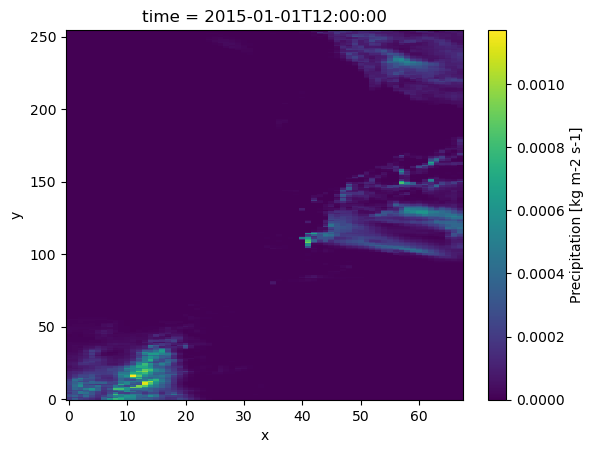

In [19]:
pr = ds["pr"]

# Mapa del día 1

pr.isel(time=0).plot()
plt.show()


In [20]:
# El punto de la grilla más cercano

import numpy as np

lat_s = -33.45 # lo más cercano a stgo centro
lon_s = -70.66

# distancia cuadrada en grados
dist = (ds.lat - lat_s)**2 + (ds.lon - lon_s)**2

# obtener los índices del punto más cercano
iy, ix = np.unravel_index(np.argmin(dist.values), dist.shape)

iy, ix


(np.int64(112), np.int64(31))

In [21]:
# Extraer la serie diaria de precipitación en ese punto

pr_point = ds["pr"][:, iy, ix]

# convertimos a mm/día:

pr_mmday = pr_point * 86400

# Definimos qué es un “dry day”
# dry day = precipitación < 1 mm/día - podemos modificarlo

dry = pr_mmday < 0.1

# Un dry spell es una secuencia continua de días secos:
# 0 = wet
# 1 = dry
# Queremos obtener las longitudes de las rachas de “1”.

import numpy as np

dry_array = dry.values.astype(int)

# diferencias: saltos entre 0 y 1
diff = np.diff(dry_array)

# inicios de dry spells
starts = np.where(diff == 1)[0] + 1

# finales de dry spells
ends   = np.where(diff == -1)[0] + 1

# caso borde si inicia seco
if dry_array[0] == 1:
    starts = np.insert(starts, 0, 0)

# caso borde si termina seco
if dry_array[-1] == 1:
    ends = np.append(ends, len(dry_array))

durations = ends - starts
durations

# Cada número corresponde a un dry spell.


array([12,  4, 16, ...,  8, 31,  2], shape=(1025,))

In [22]:
durations.min(), durations.max(), durations.mean()


(np.int64(1), np.int64(78), np.float64(6.096585365853659))

In [23]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Nos aseguramos de que sean float
d = durations.astype(float)

# Bins logarítmicos: de 1 día hasta el máximo
bins = np.logspace(np.log10(1), np.log10(d.max()), 20)

# Histograma normalizado (aprox pdf)
hist, bin_edges = np.histogram(d, bins=bins, density=True) #el true es que se convierte en distribución continua

# Centro de cada bin
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])


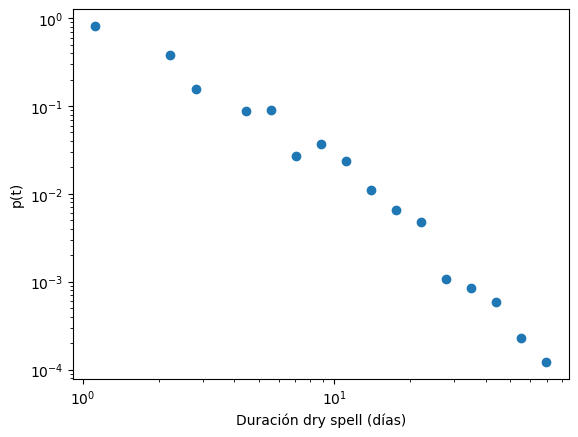

In [24]:
plt.loglog(bin_centers, hist, 'o')
plt.xlabel("Duración dry spell (días)")
plt.ylabel("p(t)")
plt.show()


In [25]:
# Estamos viendo una distribución heavy–tailed, típica de climas mediterráneos como el de Chile central.

# Esto significa:

# Hay muchos dry spells cortos (1–5 días).

# El número disminuye siguiendo un patrón más o menos de power-law.

# Aparece una “cola” donde hay eventos largos (30–100 días).

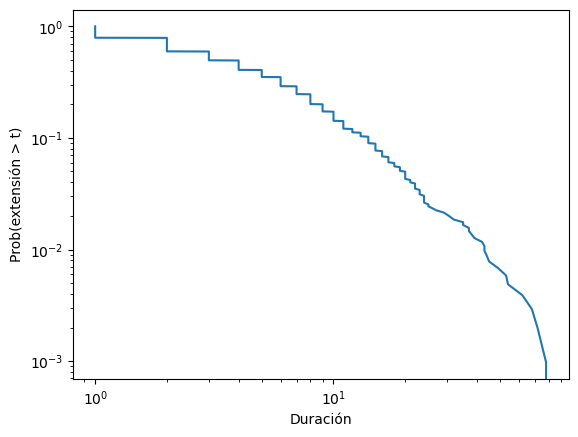

In [26]:
sorted_d = np.sort(durations)
cdf = np.arange(1,len(sorted_d)+1)/len(sorted_d)

plt.loglog(sorted_d, 1-cdf)
plt.xlabel("Duración")
plt.ylabel("Prob(extensión > t)")
plt.show()
